In [ ]:
import pandas as pd
import io
from PIL import Image

In [ ]:
# !git clone https://github.com/Sekkan-soluciones-biomedicas/FootSegmentation_4.git   # Clonamos el repositorio de archivos e imágenes.

Cloning into 'FootSegmentation_4'...
remote: Enumerating objects: 5831, done.
remote: Counting objects: 100% (1810/1810), done.
remote: Compressing objects: 100% (1651/1651), done.
remote: Total 5831 (delta 694), reused 332 (delta 144), pack-reused 4021 (from 1)
Receiving objects: 100% (5831/5831), 503.81 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (1887/1887), done.
Updating files: 100% (5334/5334), done.


In [ ]:
# !git clone https://github.com/uwm-bigdata/wound-segmentation.git

Cloning into 'wound-segmentation'...
remote: Enumerating objects: 3487, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3487 (delta 0), reused 1 (delta 0), pack-reused 3484 (from 1)
Receiving objects: 100% (3487/3487), 338.79 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
Updating files: 100% (2593/2593), done.


## Apartado para agregar el nuevo dataset:

In [ ]:
# prompt: Dame una función que tome como argumento una el path de una carpeta y me devuelva la cantidad de archivos dentro de la misma

import os

def count_files_in_folder(folder_path):

  if not os.path.isdir(folder_path):
    return 0  # O puedes lanzar una excepción si la ruta no es una carpeta válida
  file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

  # return print(f"La carpeta contiene {file_count} archivos.")
  return file_count

#### Juntamos el ds viejo y el nuevo completos en una nueva carpeta:

Creamos una carpeta ("*Ims_double*") con todas las imágenes (las del viejo DS y el nuevo DS) juntas, tanto para las imágenes como para las máscaras:

In [ ]:
# prompt: Dame una función que tome como argumento una lista de paths de carpetas, de tal forma que copie el contenido de todas las carpetas de la lista en una nueva carpeta la cual se debe crear (el path para esta última carpeta se pasará como un segundo argumento a la función)

import shutil
import os

def copy_folders_content(source_folders, destination_folder):
  """
  Copies the content of multiple source folders into a new destination folder.

  Args:
    source_folders: A list of paths to the source folders.
    destination_folder: The path to the new destination folder.-.,ma
  """

  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

  for source_folder in source_folders:
    for item in os.listdir(source_folder):
      source_path = os.path.join(source_folder, item)
      destination_path = os.path.join(destination_folder, item)

      if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
      else:
        shutil.copy2(source_path, destination_path)

# Example usage:
# source_folders = ["/path/to/folder1", "/path/to/folder2"]
# destination_folder = "/path/to/new_folder"
# copy_folders_content(source_folders, destination_folder)

**Juntamos las todas las imágenes tanto de test (o validation) como del training.**

(Se juntan las 1010 totales del DFU challenge junto con las 1010 de heridas en la piel)

$⇒ 2020$ imágenes totales con sus máscaras.

In [ ]:
# Juntamos las todas las imágenes.
copy_folders_content(["/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images", "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images"], "/content/FootSegmentation_4/images-unet/Ims_double/Imagenes")
# Juntamos las todas las máscaras.
copy_folders_content(["/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels", "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels"], "/content/FootSegmentation_4/images-unet/Ims_double/Mascaras")

## Creamos las carpetas dentro de *Ims_double* necesarias para el dataloader del modelo (-Esto es lo que ya se tenía en el otro código-):

In [ ]:
import os
import numpy as np
from PIL import Image
import shutil

# Definir rutas
data_dir = './FootSegmentation_4/images-unet/Ims_double/'  # Dirección de la carpeta Ims_double.
images_dir = os.path.join(data_dir, 'Imagenes')
masks_dir = os.path.join(data_dir, 'Mascaras')

# Definir los porcentajes de división de los datos:
train_size_perc = 0.80
val_size_perc = 0.10
test_size_perc = 1.0 - (train_size_perc + val_size_perc)

# Crear nuevas carpetas para las divisiones
train_images_dir = os.path.join(data_dir, 'train_images')
train_masks_dir = os.path.join(data_dir, 'train_masks')
val_images_dir = os.path.join(data_dir, 'val_images')
val_masks_dir = os.path.join(data_dir, 'val_masks')
test_images_dir = os.path.join(data_dir, 'test_images')
test_masks_dir = os.path.join(data_dir, 'test_masks')

# Crear directorios si no existen
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# Obtener todas las imágenes y máscaras
images = sorted(os.listdir(images_dir))  # Aseguramos que el orden sea consistente
masks = sorted(os.listdir(masks_dir))

# Verificamos que cada imagen tenga su máscara correspondiente
assert len(images) == len(masks), "El número de imágenes y máscaras no coincide"

# Asegurarse de que las imágenes y máscaras coinciden por nombre
# for img, mask in zip(images, masks):
    # assert img.split('.')[0] +'_mask' == mask.split('.')[0], f"Imagen y máscara no coinciden: {img} y {mask}"

# Mezclar datos aleatoriamente
indices = np.arange(len(images))
np.random.shuffle(indices)

# Calcular los tamaños de los conjuntos
train_size = int(train_size_perc * len(images))
val_size = int(val_size_perc * len(images))
test_size = len(images) - train_size - val_size



train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Función para copiar archivos
def copy_files(indices, src_images_dir, src_masks_dir, dest_images_dir, dest_masks_dir):
    for idx in indices:
        img_file = images[idx]
        mask_file = masks[idx]

        img_path = os.path.join(src_images_dir, img_file)
        mask_path = os.path.join(src_masks_dir, mask_file)

        shutil.copy(img_path, os.path.join(dest_images_dir, img_file))
        shutil.copy(mask_path, os.path.join(dest_masks_dir, mask_file))

# Copiar archivos a las carpetas correspondientes
copy_files(train_indices, images_dir, masks_dir, train_images_dir, train_masks_dir)
copy_files(val_indices, images_dir, masks_dir, val_images_dir, val_masks_dir)
copy_files(test_indices, images_dir, masks_dir, test_images_dir, test_masks_dir)

print("División de datos completada. Train_size: ", train_size, " . Val_size: ", val_size, " . Test_size: ", test_size )
print("Porcentajes: ",int(train_size_perc*100),'-',int(val_size_perc*100),'-',int(round(test_size_perc*100)))

División de datos completada. Train_size:  808  . Val_size:  101  . Test_size:  101
Porcentajes:  80 - 10 - 10


In [ ]:
count_files_in_folder("/content/FootSegmentation_4/images-unet/Ims_double/train_images"), count_files_in_folder("/content/FootSegmentation_4/images-unet/Ims_double/train_masks")

(808, 808)

In [ ]:
# prompt: Borra la carpeta /content/FootSegmentation_4/images-unet/Ims_double con todo su contenido

# # BORRAR CARPETA, cuidado!
# import shutil

# shutil.rmtree('/content/FootSegmentation_4/images-unet/Ims_double', ignore_errors=True)

# Definición del modelo:

In [ ]:
# Creamos la carpeta donde se guardan las predicciones durante el entrenamiento (Importante):
# !mkdir /content/saved_images/

`main.py` :

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torchvision.transforms.functional as TF

# class conv_block(nn.Module):
#     def __init__(self, in_c, out_c, act=True):
#         super().__init__()
#         layers = [nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)]
#         if act:
#             layers.append(nn.BatchNorm2d(out_c))
#             layers.append(nn.ReLU(inplace=True))
#         self.conv = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.conv(x)

# class encoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.c1 = nn.Sequential(
#             conv_block(in_c, out_c),
#             conv_block(out_c, out_c)
#         )
#         self.p1 = nn.MaxPool2d((2, 2))

#     def forward(self, x):
#         x = self.c1(x)
#         p = self.p1(x)
#         return x, p

# Bloque de código de cada capa de la Unet (donde se aplican las dos convoluciones, Además se aplica el btchnorm):
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# class unet3plus(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super().__init__()
#         """ Encoder """
#         self.e1 = encoder_block(in_channels, 64)
#         self.e2 = encoder_block(64, 128)
#         self.e3 = encoder_block(128, 256)
#         self.e4 = encoder_block(256, 512)

#         """ Bottleneck """
#         self.e5 = nn.Sequential(
#             conv_block(512, 1024),
#             conv_block(1024, 1024)
#         )

#         """ Decoders """
#         self.e1_d4 = conv_block(64, 64)
#         self.e2_d4 = conv_block(128, 64)
#         self.e3_d4 = conv_block(256, 64)
#         self.e4_d4 = conv_block(512, 64)
#         self.e5_d4 = conv_block(1024, 64)
#         self.d4 = conv_block(64 * 5, 64)

#         self.e1_d3 = conv_block(64, 64)
#         self.e2_d3 = conv_block(128, 64)
#         self.e3_d3 = conv_block(256, 64)
#         self.e4_d3 = conv_block(64, 64)
#         self.e5_d3 = conv_block(1024, 64)
#         self.d3 = conv_block(64 * 5, 64)

#         self.e1_d2 = conv_block(64, 64)
#         self.e2_d2 = conv_block(128, 64)
#         self.e3_d2 = conv_block(64, 64)
#         self.e4_d2 = conv_block(64, 64)
#         self.e5_d2 = conv_block(1024, 64)
#         self.d2 = conv_block(64 * 5, 64)

#         self.e1_d1 = conv_block(64, 64)
#         self.e2_d1 = conv_block(64, 64)
#         self.e3_d1 = conv_block(64, 64)
#         self.e4_d1 = conv_block(64, 64)
#         self.e5_d1 = conv_block(1024, 64)
#         self.d1 = conv_block(64 * 5, 64)

#         """ Output """
#         self.y1 = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, inputs):
#         e1, p1 = self.e1(inputs)
#         e2, p2 = self.e2(p1)
#         e3, p3 = self.e3(p2)
#         e4, p4 = self.e4(p3)

#         """ Bottleneck """
#         e5 = self.e5(p4)

#         """ Decoder 4 """
#         e1_d4 = F.max_pool2d(e1, kernel_size=8, stride=8)
#         e1_d4 = self.e1_d4(e1_d4)
#         e2_d4 = F.max_pool2d(e2, kernel_size=4, stride=4)
#         e2_d4 = self.e2_d4(e2_d4)
#         e3_d4 = F.max_pool2d(e3, kernel_size=2, stride=2)
#         e3_d4 = self.e3_d4(e3_d4)
#         e4_d4 = self.e4_d4(e4)
#         e5_d4 = F.interpolate(e5, scale_factor=2, mode="bilinear", align_corners=True)
#         e5_d4 = self.e5_d4(e5_d4)
#         d4 = torch.cat([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4], dim=1)
#         d4 = self.d4(d4)

#         """ Decoder 3 """
#         e1_d3 = F.max_pool2d(e1, kernel_size=4, stride=4)
#         e1_d3 = self.e1_d3(e1_d3)
#         e2_d3 = F.max_pool2d(e2, kernel_size=2, stride=2)
#         e2_d3 = self.e2_d3(e2_d3)
#         e3_d3 = self.e3_d3(e3)
#         e4_d3 = F.interpolate(d4, scale_factor=2, mode="bilinear", align_corners=True)
#         e4_d3 = self.e4_d3(e4_d3)
#         e5_d3 = F.interpolate(e5, scale_factor=4, mode="bilinear", align_corners=True)
#         e5_d3 = self.e5_d3(e5_d3)
#         d3 = torch.cat([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3], dim=1)
#         d3 = self.d3(d3)

#         """ Decoder 2 """
#         e1_d2 = F.max_pool2d(e1, kernel_size=2, stride=2)
#         e1_d2 = self.e1_d2(e1_d2)
#         e2_d2 = self.e2_d2(e2)
#         e3_d2 = F.interpolate(d3, scale_factor=2, mode="bilinear", align_corners=True)
#         e3_d2 = self.e3_d2(e3_d2)
#         e4_d2 = F.interpolate(d4, scale_factor=4, mode="bilinear", align_corners=True)
#         e4_d2 = self.e4_d2(e4_d2)
#         e5_d2 = F.interpolate(e5, scale_factor=8, mode="bilinear", align_corners=True)
#         e5_d2 = self.e5_d2(e5_d2)
#         d2 = torch.cat([e1_d2, e2_d2, e3_d2, e4_d2, e5_d2], dim=1)
#         d2 = self.d2(d2)

#         """ Decoder 1 """
#         e1_d1 = self.e1_d1(e1)
#         e2_d1 = F.interpolate(d2, scale_factor=2, mode="bilinear", align_corners=True)
#         e2_d1 = self.e2_d1(e2_d1)
#         e3_d1 = F.interpolate(d3, scale_factor=4, mode="bilinear", align_corners=True)
#         e3_d1 = self.e3_d1(e3_d1)
#         e4_d1 = F.interpolate(d4, scale_factor=8, mode="bilinear", align_corners=True)
#         e4_d1 = self.e4_d1(e4_d1)
#         e5_d1 = F.interpolate(e5, scale_factor=16, mode="bilinear", align_corners=True)
#         e5_d1 = self.e5_d1(e5_d1)
#         d1 = torch.cat([e1_d1, e2_d1, e3_d1, e4_d1, e5_d1], dim=1)
#         d1 = self.d1(d1)

#         """ Output """
#         y1 = self.y1(d1)
#         return y1

class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

        # Down part of Unet:
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of Unet:
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottlenech = DoubleConv(features[-1], features[-1]*2) # Medium part
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #Final part


    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottlenech(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [ ]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [ ]:
# import torch
# import torch.nn as nn
# import  torchvision.transforms.functional as TF

# # Bloque de código de cada capa de la Unet (donde se aplican las dos convoluciones, Además se aplica el btchnorm):
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNET(nn.Module):
#     def __init__(
#         self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
#     ):
#         super(UNET, self).__init__()
#         self.downs = nn.ModuleList()
#         self.ups = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

#         # Down part of Unet:
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         # Up part of Unet:
#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     feature*2, feature, kernel_size=2, stride=2,
#                 )
#             )
#             self.ups.append(DoubleConv(feature*2, feature))

#         self.bottlenech = DoubleConv(features[-1], features[-1]*2) # Medium part
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #Final part


#     def forward(self, x):
#         skip_connections = []
#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottlenech(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)

#         return self.final_conv(x)

# def test():
#     x = torch.randn((3, 1, 161, 161))
#     model = UNET(in_channels=1, out_channels=1)
#     preds = model(x)
#     print(preds.shape)
#     print(x.shape)
#     assert preds.shape == x.shape

# # if __name__ == "__main__":
# #     test()

`dataset.py` :

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np


class MiccaiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform =  transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

`utils.py`:

In [ ]:
import torch
import torchvision
# from dataset import MiccaiDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory = True,
):
    train_ds = MiccaiDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = MiccaiDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_dice_acc(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds =  (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += (torch.numel(preds))
            dice_score += (2* (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    accuracy = num_correct / num_pixels if num_pixels > 0 else 0 # Calculate accuracy
    print(
        f"Got {num_correct}/{num_pixels} with acc {accuracy*100:.3f}"
    )

    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    return dice_score/len(loader), accuracy

def save_predictions_as_imgs(
        loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}")  # para colab
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/target_{idx}.png")

    model.train()

`train.py` :

In [ ]:
from re import L
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


def dice_loss(input, target):
    smooth = 1.0
    input = torch.sigmoid(input)  # Aplicar sigmoide para obtener probabilidades
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))


# Hyperparameters etc.
LEARNING_RATE = 5e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
# NUM_EPOCHS = 83
NUM_WORKERS = 2
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = True
# TRAIN_IMG_DIR = "FootSegmentation_4/images-unet/IMs29Ago/train_images"
# TRAIN_MASK_DIR = "FootSegmentation_4/images-unet/IMs29Ago/train_masks"
# VAL_IMG_DIR = "FootSegmentation_4/images-unet/IMs29Ago/val_images"
# VAL_MASK_DIR = "FootSegmentation_4/images-unet/IMs29Ago/val_masks"
# TRAIN_IMG_DIR = "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images"
# TRAIN_MASK_DIR = "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels"
# VAL_IMG_DIR = "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images"
# VAL_MASK_DIR = "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels"
TRAIN_IMG_DIR = "/content/FootSegmentation_4/images-unet/Ims_double/train_images"
TRAIN_MASK_DIR = "/content/FootSegmentation_4/images-unet/Ims_double/train_masks"
VAL_IMG_DIR = "/content/FootSegmentation_4/images-unet/Ims_double/val_images"
VAL_MASK_DIR = "/content/FootSegmentation_4/images-unet/Ims_double/val_masks"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0  # Inicializar la pérdida total
    num_batches = 0  # Inicializar el contador de batches

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward:
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward:
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item)

        # Acumular la pérdida y contar los batches
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches

    return avg_loss  # Devolver la pérdida promedio


def main(NUM_EPOCHS=10):
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2()
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    # loss_fn = nn.BCEWithLogitsLoss()
    loss_fn = dice_loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5) # Reduce LR if validation loss plateaus

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

    # if LOAD_MODEL:
    #     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    scaler = torch.cuda.amp.GradScaler()
    L_dice = []
    L_loss = []
    L_accuracy = []
    best_dice_score = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch: {epoch + 1}")
        epoch_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        L_loss.append(epoch_loss)
        scheduler.step(epoch_loss) # Update scheduler based on training loss

        # Check accuracy on validation set
        dc, acc = check_dice_acc(val_loader, model, device=DEVICE)
        L_dice.append(dc)
        L_accuracy.append(acc)

        # Save best model, based in dice score.
        if dc > best_dice_score:
          best_dice_score = dc
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
          }
          # torch.save(checkpoint, f"model_checkpoint_epoch_{epoch+1}.pth")
          torch.save(checkpoint, "best_model_checkpoint.pth")

        # Save some example predictions to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )
    return model, L_dice, L_loss, L_accuracy

## Entrenamos el modelo:

In [ ]:
model3, L_dice2, L_loss2, L_acc2 = main(NUM_EPOCHS = 110)

<ipython-input-47-c2fd48f339fc>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]<ipython-input-47-c2fd48f339fc>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 51/51 [00:17<00:00,  2.88it/s, loss=<built-in method item of Tensor object at 0x783e1c1763e0>]


Got 5733145/5817600 with acc 98.548
Dice score: 0.5895883440971375
Epoch: 2


100%|██████████| 51/51 [00:18<00:00,  2.79it/s, loss=<built-in method item of Tensor object at 0x783e1c1b4db0>]


Got 5682652/5817600 with acc 97.680
Dice score: 0.5911434292793274
Epoch: 3


100%|██████████| 51/51 [00:20<00:00,  2.49it/s, loss=<built-in method item of Tensor object at 0x783e1c175f80>]


Got 5590835/5817600 with acc 96.102
Dice score: 0.4746289551258087
Epoch: 4


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e1c168310>]


Got 5662024/5817600 with acc 97.326
Dice score: 0.5578983426094055
Epoch: 5


100%|██████████| 51/51 [00:18<00:00,  2.80it/s, loss=<built-in method item of Tensor object at 0x783e1c180540>]


Got 5699014/5817600 with acc 97.962
Dice score: 0.6015352010726929
Epoch: 6


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e1c1b7420>]


Got 5692042/5817600 with acc 97.842
Dice score: 0.5986704230308533
Epoch: 7


100%|██████████| 51/51 [00:18<00:00,  2.73it/s, loss=<built-in method item of Tensor object at 0x783e1c182930>]


Got 5714274/5817600 with acc 98.224
Dice score: 0.6520792245864868
Epoch: 8


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c180d60>]


Got 5687986/5817600 with acc 97.772
Dice score: 0.6101909875869751
Epoch: 9


100%|██████████| 51/51 [00:18<00:00,  2.79it/s, loss=<built-in method item of Tensor object at 0x783e1c181710>]


Got 5578350/5817600 with acc 95.887
Dice score: 0.4630759656429291
Epoch: 10


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e1c1d14e0>]


Got 5755487/5817600 with acc 98.932
Dice score: 0.7138707041740417
Epoch: 11


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e1c182980>]


Got 5694338/5817600 with acc 97.881
Dice score: 0.6114531755447388
Epoch: 12


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c1d0180>]


Got 5689125/5817600 with acc 97.792
Dice score: 0.599273681640625
Epoch: 13


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e1c1835b0>]


Got 5619859/5817600 with acc 96.601
Dice score: 0.5106346607208252
Epoch: 14


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c1d4130>]


Got 5730263/5817600 with acc 98.499
Dice score: 0.6814671158790588
Epoch: 15


100%|██████████| 51/51 [00:18<00:00,  2.71it/s, loss=<built-in method item of Tensor object at 0x783e1c1ec590>]


Got 5737842/5817600 with acc 98.629
Dice score: 0.7122332453727722
Epoch: 16


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c1ec540>]


Got 5731485/5817600 with acc 98.520
Dice score: 0.6946302056312561
Epoch: 17


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e1c1ee4d0>]


Got 5767602/5817600 with acc 99.141
Dice score: 0.7793914675712585
Epoch: 18


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c1b6890>]


Got 5755010/5817600 with acc 98.924
Dice score: 0.7313563823699951
Epoch: 19


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e1c1d5670>]


Got 5727180/5817600 with acc 98.446
Dice score: 0.6748697757720947
Epoch: 20


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e1c1d6250>]


Got 5750961/5817600 with acc 98.855
Dice score: 0.7404739260673523
Epoch: 21


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e1c1d4950>]


Got 5775996/5817600 with acc 99.285
Dice score: 0.7922466993331909
Epoch: 22


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e1c1d1300>]


Got 5754938/5817600 with acc 98.923
Dice score: 0.7578715682029724
Epoch: 23


100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=<built-in method item of Tensor object at 0x783e04f01d50>]


Got 5759187/5817600 with acc 98.996
Dice score: 0.7588508129119873
Epoch: 24


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f013f0>]


Got 5784292/5817600 with acc 99.427
Dice score: 0.8363601565361023
Epoch: 25


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f00720>]


Got 5769841/5817600 with acc 99.179
Dice score: 0.7872416377067566
Epoch: 26


100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=<built-in method item of Tensor object at 0x783e04f34720>]


Got 5782065/5817600 with acc 99.389
Dice score: 0.8233092427253723
Epoch: 27


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04f34400>]


Got 5682687/5817600 with acc 97.681
Dice score: 0.6127195358276367
Epoch: 28


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f35d50>]


Got 5786316/5817600 with acc 99.462
Dice score: 0.8401051163673401
Epoch: 29


100%|██████████| 51/51 [00:18<00:00,  2.71it/s, loss=<built-in method item of Tensor object at 0x783e04f34810>]


Got 5784580/5817600 with acc 99.432
Dice score: 0.8457985520362854
Epoch: 30


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f02ed0>]


Got 5777012/5817600 with acc 99.302
Dice score: 0.8193480968475342
Epoch: 31


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f413a0>]


Got 5786713/5817600 with acc 99.469
Dice score: 0.8522442579269409
Epoch: 32


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04f40db0>]


Got 5787768/5817600 with acc 99.487
Dice score: 0.8602485656738281
Epoch: 33


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f420c0>]


Got 5784800/5817600 with acc 99.436
Dice score: 0.8503350019454956
Epoch: 34


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f68310>]


Got 5787254/5817600 with acc 99.478
Dice score: 0.8391557931900024
Epoch: 35


100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=<built-in method item of Tensor object at 0x783e04f689f0>]


Got 5791251/5817600 with acc 99.547
Dice score: 0.8707476854324341
Epoch: 36


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e1c1d49f0>]


Got 5792647/5817600 with acc 99.571
Dice score: 0.8741405606269836
Epoch: 37


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f68860>]


Got 5793454/5817600 with acc 99.585
Dice score: 0.8801546096801758
Epoch: 38


100%|██████████| 51/51 [00:18<00:00,  2.71it/s, loss=<built-in method item of Tensor object at 0x783e04f42ca0>]


Got 5788682/5817600 with acc 99.503
Dice score: 0.858157217502594
Epoch: 39


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f31440>]


Got 5791900/5817600 with acc 99.558
Dice score: 0.8741465210914612
Epoch: 40


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04f31d50>]


Got 5791471/5817600 with acc 99.551
Dice score: 0.8694589734077454
Epoch: 41


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f31d50>]


Got 5792866/5817600 with acc 99.575
Dice score: 0.877792239189148
Epoch: 42


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f33330>]


Got 5761992/5817600 with acc 99.044
Dice score: 0.7782021164894104
Epoch: 43


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e04f40720>]


Got 5794059/5817600 with acc 99.595
Dice score: 0.8863525390625
Epoch: 44


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04f8d5d0>]


Got 5794291/5817600 with acc 99.599
Dice score: 0.8888972401618958
Epoch: 45


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04f8ca40>]


Got 5793496/5817600 with acc 99.586
Dice score: 0.8833348751068115
Epoch: 46


100%|██████████| 51/51 [00:18<00:00,  2.69it/s, loss=<built-in method item of Tensor object at 0x783e04f8c4a0>]


Got 5792031/5817600 with acc 99.560
Dice score: 0.8742470741271973
Epoch: 47


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f9c180>]


Got 5795915/5817600 with acc 99.627
Dice score: 0.8954250812530518
Epoch: 48


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04f8eb10>]


Got 5795072/5817600 with acc 99.613
Dice score: 0.8869127035140991
Epoch: 49


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04fa6b60>]


Got 5791851/5817600 with acc 99.557
Dice score: 0.8766084909439087
Epoch: 50


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fa7880>]


Got 5796276/5817600 with acc 99.633
Dice score: 0.8939886093139648
Epoch: 51


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04facc20>]


Got 5795856/5817600 with acc 99.626
Dice score: 0.8918390870094299
Epoch: 52


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04f9cf90>]


Got 5794835/5817600 with acc 99.609
Dice score: 0.8878598213195801
Epoch: 53


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04f9c860>]


Got 5793274/5817600 with acc 99.582
Dice score: 0.8757437467575073
Epoch: 54


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04f9f330>]


Got 5789141/5817600 with acc 99.511
Dice score: 0.8411720395088196
Epoch: 55


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fcc040>]


Got 5794694/5817600 with acc 99.606
Dice score: 0.8800874352455139
Epoch: 56


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e04fd1030>]


Got 5797135/5817600 with acc 99.648
Dice score: 0.8973294496536255
Epoch: 57


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fd2930>]


Got 5795469/5817600 with acc 99.620
Dice score: 0.8861948251724243
Epoch: 58


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fd39c0>]


Got 5794996/5817600 with acc 99.611
Dice score: 0.8872122764587402
Epoch: 59


100%|██████████| 51/51 [00:18<00:00,  2.73it/s, loss=<built-in method item of Tensor object at 0x783e04fe0cc0>]


Got 5795165/5817600 with acc 99.614
Dice score: 0.8859735727310181
Epoch: 60


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fe0540>]


Got 5796316/5817600 with acc 99.634
Dice score: 0.8891294598579407
Epoch: 61


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04fe1f30>]


Got 5795943/5817600 with acc 99.628
Dice score: 0.8885776400566101
Epoch: 62


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04fe2a20>]


Got 5796899/5817600 with acc 99.644
Dice score: 0.8950283527374268
Epoch: 63


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04fe2980>]


Got 5795442/5817600 with acc 99.619
Dice score: 0.8890193104743958
Epoch: 64


100%|██████████| 51/51 [00:18<00:00,  2.73it/s, loss=<built-in method item of Tensor object at 0x783e04ff4360>]


Got 5795781/5817600 with acc 99.625
Dice score: 0.88980633020401
Epoch: 65


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ff9260>]


Got 5791419/5817600 with acc 99.550
Dice score: 0.8572283387184143
Epoch: 66


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04ff8310>]


Got 5791624/5817600 with acc 99.553
Dice score: 0.8689382672309875
Epoch: 67


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ff8f90>]


Got 5796078/5817600 with acc 99.630
Dice score: 0.8889557719230652
Epoch: 68


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ffb790>]


Got 5794569/5817600 with acc 99.604
Dice score: 0.8831236958503723
Epoch: 69


100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=<built-in method item of Tensor object at 0x783e04e0c180>]


Got 5796679/5817600 with acc 99.640
Dice score: 0.8913584351539612
Epoch: 70


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e1ca90>]


Got 5797384/5817600 with acc 99.652
Dice score: 0.8993654847145081
Epoch: 71


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e344a0>]


Got 5798546/5817600 with acc 99.672
Dice score: 0.9037628173828125
Epoch: 72


100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=<built-in method item of Tensor object at 0x783e04e1fe20>]


Got 5798289/5817600 with acc 99.668
Dice score: 0.9017577767372131
Epoch: 73


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e39df0>]


Got 5795360/5817600 with acc 99.618
Dice score: 0.88435298204422
Epoch: 74


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e3a4d0>]


Got 5796448/5817600 with acc 99.636
Dice score: 0.8922219276428223
Epoch: 75


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e3bf60>]


Got 5798452/5817600 with acc 99.671
Dice score: 0.9035564661026001
Epoch: 76


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e2ca40>]


Got 5797225/5817600 with acc 99.650
Dice score: 0.8977293968200684
Epoch: 77


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e04e2c0e0>]


Got 5798181/5817600 with acc 99.666
Dice score: 0.901955783367157
Epoch: 78


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e2ede0>]


Got 5791717/5817600 with acc 99.555
Dice score: 0.8659656643867493
Epoch: 79


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e2f510>]


Got 5796424/5817600 with acc 99.636
Dice score: 0.8882347941398621
Epoch: 80


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e54130>]


Got 5797704/5817600 with acc 99.658
Dice score: 0.9005715250968933
Epoch: 81


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e60cc0>]


Got 5789173/5817600 with acc 99.511
Dice score: 0.8469097018241882
Epoch: 82


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e04e62020>]


Got 5794057/5817600 with acc 99.595
Dice score: 0.879011869430542
Epoch: 83


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e61a30>]


Got 5792039/5817600 with acc 99.561
Dice score: 0.8648279905319214
Epoch: 84


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04e605e0>]


Got 5794642/5817600 with acc 99.605
Dice score: 0.881692111492157
Epoch: 85


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04e58310>]


Got 5799612/5817600 with acc 99.691
Dice score: 0.9088074564933777
Epoch: 86


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04e6f560>]


Got 5799192/5817600 with acc 99.684
Dice score: 0.9063209295272827
Epoch: 87


100%|██████████| 51/51 [00:18<00:00,  2.75it/s, loss=<built-in method item of Tensor object at 0x783e04e744f0>]


Got 5798250/5817600 with acc 99.667
Dice score: 0.9025023579597473
Epoch: 88


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04e794e0>]


Got 5795805/5817600 with acc 99.625
Dice score: 0.8847881555557251
Epoch: 89


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e78ea0>]


Got 5796839/5817600 with acc 99.643
Dice score: 0.8911469578742981
Epoch: 90


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04e7a9d0>]


Got 5799660/5817600 with acc 99.692
Dice score: 0.9087826013565063
Epoch: 91


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04e78c70>]


Got 5798629/5817600 with acc 99.674
Dice score: 0.9025241732597351
Epoch: 92


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ea0ae0>]


Got 5797022/5817600 with acc 99.646
Dice score: 0.8921269178390503
Epoch: 93


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ea1c60>]


Got 5798980/5817600 with acc 99.680
Dice score: 0.9059990644454956
Epoch: 94


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04ea2f70>]


Got 5799354/5817600 with acc 99.686
Dice score: 0.9071382284164429
Epoch: 95


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ea2d90>]


Got 5799645/5817600 with acc 99.691
Dice score: 0.9081864356994629
Epoch: 96


100%|██████████| 51/51 [00:18<00:00,  2.72it/s, loss=<built-in method item of Tensor object at 0x783e04eac090>]


Got 5798884/5817600 with acc 99.678
Dice score: 0.9048663377761841
Epoch: 97


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ead170>]


Got 5797577/5817600 with acc 99.656
Dice score: 0.8966012001037598
Epoch: 98


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04eac1d0>]


Got 5798269/5817600 with acc 99.668
Dice score: 0.8994408249855042
Epoch: 99


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04eacef0>]


Got 5798633/5817600 with acc 99.674
Dice score: 0.9023965001106262
Epoch: 100


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04eaf100>]


Got 5797939/5817600 with acc 99.662
Dice score: 0.8978944420814514
Epoch: 101


100%|██████████| 51/51 [00:18<00:00,  2.73it/s, loss=<built-in method item of Tensor object at 0x783e04eade90>]


Got 5797532/5817600 with acc 99.655
Dice score: 0.8977795839309692
Epoch: 102


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ec12b0>]


Got 5800670/5817600 with acc 99.709
Dice score: 0.9130621552467346
Epoch: 103


100%|██████████| 51/51 [00:18<00:00,  2.77it/s, loss=<built-in method item of Tensor object at 0x783e04ee4090>]


Got 5800001/5817600 with acc 99.697
Dice score: 0.9107006788253784
Epoch: 104


100%|██████████| 51/51 [00:18<00:00,  2.73it/s, loss=<built-in method item of Tensor object at 0x783e04ee4d10>]


Got 5798505/5817600 with acc 99.672
Dice score: 0.9001107215881348
Epoch: 105


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ee5a80>]


Got 5799505/5817600 with acc 99.689
Dice score: 0.9081279635429382
Epoch: 106


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ee5120>]


Got 5798897/5817600 with acc 99.679
Dice score: 0.9049801826477051
Epoch: 107


100%|██████████| 51/51 [00:18<00:00,  2.76it/s, loss=<built-in method item of Tensor object at 0x783e04ee5850>]


Got 5799560/5817600 with acc 99.690
Dice score: 0.9073507785797119
Epoch: 108


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ef4220>]


Got 5796445/5817600 with acc 99.636
Dice score: 0.8910681009292603
Epoch: 109


100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=<built-in method item of Tensor object at 0x783e04f9d350>]


Got 5795486/5817600 with acc 99.620
Dice score: 0.8837989568710327
Epoch: 110


100%|██████████| 51/51 [00:18<00:00,  2.78it/s, loss=<built-in method item of Tensor object at 0x783e04ef51c0>]


Got 5799329/5817600 with acc 99.686
Dice score: 0.9061821699142456


In [ ]:
# prompt: carga el modelo con las mejores métricas (guardado en el archivo best_model_checkpoint.pth) asignándolo a la variable model2

import torch

# Assuming 'best_model_checkpoint.pth' is in the current working directory.
# If not, adjust the path accordingly.
checkpoint = torch.load("best_model_checkpoint.pth")

# Assuming UNET class is defined in the current scope
# If not, make sure the definition of UNET is available before this line

model2 = UNET(in_channels=3, out_channels=1).to(DEVICE)
model2.load_state_dict(checkpoint["state_dict"])
# model2.eval() #set to evaluation mode

<ipython-input-63-a4caee1a9585>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_checkpoint.pth")


<All keys matched successfully>

In [ ]:
# GUARDAR EL MODELO EN UN ZIP:
# prompt: Guarda en modelo model1 que acabo de entrenar en un archivo zip, para que después lo pueda cargar en otro script

import zipfile
import os

def save_model_to_zip(model, filename="model2.zip"):
  """Saves the trained PyTorch model to a zip file.

  Args:
    model: The trained PyTorch model.
    filename: The name of the zip file to save the model to.
  """
  # Save the model state dictionary
  torch.save(model.state_dict(), "model2_weights.pth")

  # Create a zip file containing the model weights
  with zipfile.ZipFile(filename, 'w') as zipf:
    zipf.write("model2_weights.pth")

  # Remove the temporary weights file
  os.remove("model2_weights.pth")


save_model_to_zip(model2)

# Hacer predicciones con el modelo:

In [ ]:
# CARGAR EL MODELO DEL ZIP (solo para guardar este código):
# prompt: Ahora dame el código con el que lo cargaría en el otro script, asignándolo a la variable model2

import torch
# from model import UNET  # Assuming your UNET class is in a file named model.py
import zipfile

def load_model_from_zip(zip_filename, device="cpu"):
  """Loads a PyTorch model from a zip file.

  Args:
    zip_filename: The name of the zip file containing the model weights.
    device: The device to load the model onto (e.g., "cuda" or "cpu").

  Returns:
    The loaded PyTorch model.
  """

  with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extractall()

  model = UNET(in_channels=3, out_channels=1).to(device)
  model.load_state_dict(torch.load("model2_weights.pth", map_location=device))

  return model


# Example of how to load the model
model2 = load_model_from_zip("model2.zip", device=DEVICE)

<ipython-input-65-057eabf15458>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_weights.pth", map_location=device))


In [ ]:
# prompt: Obtén el path de una imágen escogida aleatoriamente del folder /content/FootSegmentation_4/images-unet/IMs29Ago/test_images/

import os
import random

def get_random_image_path(folder_path):
  """
  Obtiene el path de una imagen escogida aleatoriamente del folder especificado.

  Args:
    folder_path: Ruta a la carpeta que contiene las imágenes.

  Returns:
    Path de la imagen aleatoria, o None si la carpeta está vacía.
  """
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
  if not image_files:
    return None
  random_image_file = random.choice(image_files)
  return os.path.join(folder_path, random_image_file)


image_folder = "/content/FootSegmentation_4/images-unet/Ims_double/test_images"
random_image_path = get_random_image_path(image_folder)

if random_image_path:
  print(f"Path de la imagen aleatoria: {random_image_path}")
else:
  print(f"La carpeta '{image_folder}' está vacía.")

Path de la imagen aleatoria: /content/FootSegmentation_4/images-unet/Ims_double/test_images/0408.png


In [ ]:
# TOMA EL MODELO CARGADO EN LA CELDA ANETERIOR Y HACE UNA PREDICCIÓN:
# prompt: Ahora haz la predicción (y muéstrala) de una imagen de mi carpeta /content/FootSegmentation_4/images-unet/IMs29Ago/test_images      con el modelo que acabo de entrenar

# Assuming your model is named 'model' and is already loaded with the trained weights.
# You'll need to adjust the paths and file names as needed.

import torch
import torchvision
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the path to the image you want to predict
image_path = random_image_path  # Replace with your image path

# Load the image
image = np.array(Image.open(image_path).convert("RGB"))

# Apply the same transformations used during training
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

augmentations = val_transforms(image=image)
image = augmentations["image"]

# Move the image to the device (CPU or GPU)
image = image.unsqueeze(0).to(DEVICE)


# Make the prediction
with torch.no_grad():
  prediction = torch.sigmoid(model2(image))
  prediction = (prediction > 0.5).float()

# Resize the prediction to 512x512
prediction = torchvision.transforms.functional.resize(prediction, size=(512, 512))

# Save the prediction as an image
torchvision.utils.save_image(prediction, "predicted_mask2.png")

print("Prediction saved as 'predicted_mask2.png'")

Prediction saved as 'predicted_mask2.png'


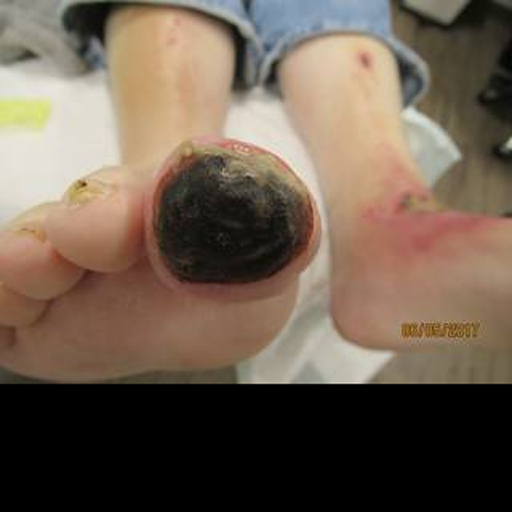

In [ ]:
Image.open(random_image_path)

Guardamos las listas en un csv:

In [ ]:
# prompt: Guarda las listas L_dice2, L_loss2, así como las epocas correspondientes en una primera columna en un csv

import pandas as pd

# Crear un DataFrame con las listas y las épocas
data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': [x.cpu().numpy() for x in L_dice2], 'Loss': L_loss2, 'Accuracy':[x.cpu().numpy() for x in L_acc2]}
# data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': L_dice2, 'Loss': L_loss2, 'Accuracy':L_acc2}
# data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': L_dice2, 'Loss': L_loss2, 'Accuracy':L_acc2}
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
df.to_csv('metrics.csv', index=False)

# Gráficas de dice y loss funct. por cada época:

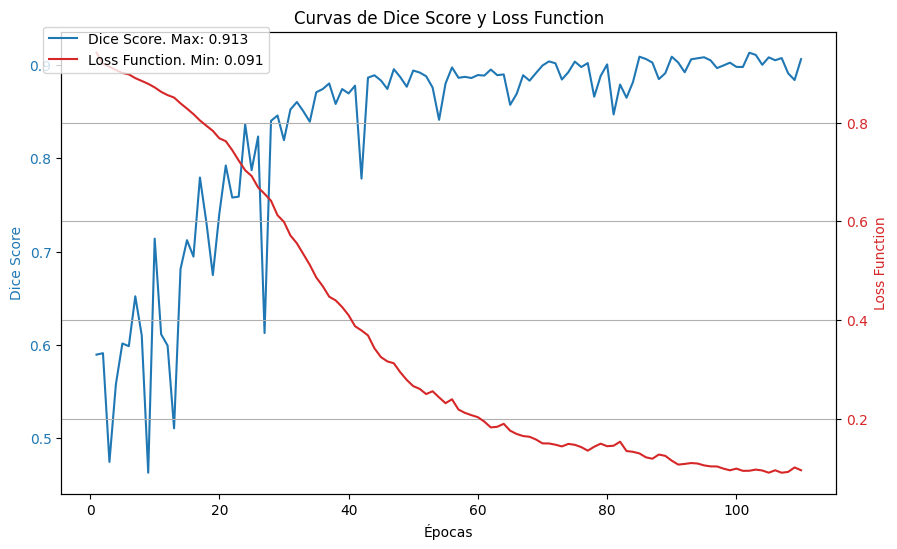

In [ ]:
# prompt: Graficame [1,2,3] vs [4,5,6] en una gráfica elegante y bonita

import matplotlib.pyplot as plt


# Convert L_dice1 and L_loss1 to NumPy arrays
# L_dice1 = [x.cpu().numpy() for x in L_dice1] # Move tensors to CPU and convert to NumPy
# L_dice2 = [x.cpu().numpy() for x in L_dice2]

# Datos de ejemplo (reemplaza con tus datos reales)
epochs = range(1, len(L_dice2) + 1)

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la curva de Dice Score
color = 'tab:blue'
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Dice Score', color=color)
ax1.plot(epochs, L_dice2, color=color, label=f'Dice Score. Max: {max(L_dice2):.3f}')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la Loss Function
ax2 = ax1.twinx()  # Compartir el eje x

color = 'tab:red'
ax2.set_ylabel('Loss Function', color=color)
ax2.plot(epochs, L_loss2, color=color, label=f'Loss Function. Min: {min(L_loss2):.3f}')
ax2.tick_params(axis='y', labelcolor=color)

# Agregar leyenda y título
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Curvas de Dice Score y Loss Function')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Métricas con el test set:

In [ ]:
# prompt: ahora calculame el accuracy y el coeficiente dice del modelo entrenado con ayuda de las carpetas /content/FootSegmentation_4/images-unet/IMs29Ago/test_images y /content/FootSegmentation_4/images-unet/IMs29Ago/test_masks

def calculate_metrics(test_image_dir, test_mask_dir, model, device="cuda", image_height=240, image_width=240):
  """Calculates accuracy and Dice coefficient for a trained model on a test dataset.

  Args:
    test_image_dir: Path to the directory containing test images.
    test_mask_dir: Path to the directory containing test masks.
    model: The trained PyTorch model.
    device: The device to run the model on (e.g., "cuda" or "cpu").
    image_height: The height to resize images to before feeding them to the model.
    image_width: The width to resize images to before feeding them to the model.

  Returns:
    A tuple containing the accuracy and Dice coefficient.
  """

  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  val_transforms = A.Compose(
      [
          A.Resize(height=image_height, width=image_width),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ]
  )


  image_files = [f for f in os.listdir(test_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
  for image_file in image_files:
      img_path = os.path.join(test_image_dir, image_file)
      mask_path = os.path.join(test_mask_dir, image_file)
      image = np.array(Image.open(img_path).convert("RGB"))
      mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
      mask[mask == 255.0] = 1.0

      augmentations = val_transforms(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]


      x = image.unsqueeze(0).to(device)
      y = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)


      with torch.no_grad():
          preds = torch.sigmoid(model(x))
          preds = (preds > 0.5).float()
          num_correct += (preds == y).sum()
          num_pixels += torch.numel(preds)
          dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

  accuracy = num_correct / num_pixels if num_pixels > 0 else 0
  dice_coefficient = dice_score / len(image_files) if len(image_files) > 0 else 0

  model.train()

  return accuracy, dice_coefficient

# Example usage:
# test_image_dir = "/content/FootSegmentation_4/images-unet/IMs29Ago/test_images"
# test_mask_dir = "/content/FootSegmentation_4/images-unet/IMs29Ago/test_masks"
test_image_dir = "/content/FootSegmentation_4/images-unet/Ims_double/test_images"
test_mask_dir = "/content/FootSegmentation_4/images-unet/Ims_double/test_masks"

accuracy, dice_coefficient = calculate_metrics(test_image_dir, test_mask_dir, model2, device=DEVICE)
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")

<ipython-input-71-67db87e0e89f>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)


Accuracy: 0.9976
Dice Coefficient: 0.8053


In [ ]:
# Best metrics:
print(f"Best_dice: {max(L_dice2):.4f}")
print(f"Best_accuracy: {max(L_acc2):.4f}")
print(f"Best_loss: {min(L_loss2):.4f}")
print(f"Best_epoch: {L_dice2.index(max(L_dice2))+1}")

Best_dice: 0.9131
Best_accuracy: 0.9971
Best_loss: 0.0911
Best_epoch: 102


In [ ]:
calculate_metrics(VAL_IMG_DIR, VAL_MASK_DIR, model2, device=DEVICE)

<ipython-input-71-67db87e0e89f>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)


(tensor(0.9971, device='cuda:0'), tensor(0.8512, device='cuda:0'))